
# Perceptual Image Generator — **Calibrated Display Mapping**
This notebook generates Gaussian-blob stimuli in additive white noise (as in the paper) **and**
uses a *fixed, linear* mapping from cd/m² → 8‑bit so the images look like the article:
- Mean luminance ≈ **28 cd/m²** maps to **mid‑gray (128)**.
- No per-image contrast stretching (preserves relative SNR).
- All **computations** (mean, SD, RMS, SNR) are done on **float cd/m²** arrays.

**Sections**
1. Config & constants
2. Stimulus generation (float)
3. Calibrated mapping for display/save
4. Visual demos (absent vs present, components)
5. Batch export to dataset (PNG + optional .npy)
6. Verification (single‑trial sanity + dataset checks)


In [10]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import csv, json, math, random

# ====== Experiment constants ======
MEAN_LUMINANCE = 28.0          # cd/m^2
NOISE_SD = 4.375               # cd/m^2 (RMS)
FIELD_DEG = 15.0               # degrees
PIXELS_PER_DEG = 1.0 / 0.037   # ≈27.027 px/deg
IMG_SIZE = int(round(FIELD_DEG * PIXELS_PER_DEG))  # ≈405 px
SIGMA_DEG = 0.5
SIGMA_PX  = SIGMA_DEG * PIXELS_PER_DEG             # ≈13.5 px

# Peak contrasts → amplitudes = contrast * MEAN_LUMINANCE
PEAK_CONTRAST_EQUAL  = 0.06
PEAK_CONTRAST_WEAK   = 0.02
PEAK_CONTRAST_STRONG = 0.12

TARGET_SNRS = {"equal": 3.07, "weak": 0.77, "strong": 13.8}

# ====== Display calibration (fixed linear mapping, like the article) ======
DISPLAY_MEAN_8BIT = 128.0                   # where 28 cd/m^2 should land on 0–255
DISPLAY_GAIN      = DISPLAY_MEAN_8BIT / MEAN_LUMINANCE   # ≈ 128/28 ≈ 4.57

# RNG (set to an int for reproducibility)
RANDOM_SEED = None
if RANDOM_SEED is not None:
    np.random.seed(RANDOM_SEED)

IMG_SIZE, SIGMA_PX, DISPLAY_GAIN


(405, 13.513513513513514, 4.571428571428571)

In [11]:

def gaussian_blob(size, sigma_px, amplitude, center=None):
    """
    2D Gaussian (signal-only) in luminance units (cd/m^2).
    amplitude is the peak increment above baseline.
    """
    h = w = size
    if center is None:
        cy, cx = (h-1)/2.0, (w-1)/2.0
    else:
        cy, cx = center
    y = np.arange(h)[:, None]
    x = np.arange(w)[None, :]
    g = np.exp(-(((y - cy)**2 + (x - cx)**2) / (2*sigma_px**2)))
    return amplitude * g

def white_noise(size, mean_lum=MEAN_LUMINANCE, sigma=NOISE_SD):
    """Gaussian white noise field in cd/m^2."""
    return np.random.normal(mean_lum, sigma, (size, size))

def make_stimulus(present=True, peak_contrast=PEAK_CONTRAST_EQUAL):
    """
    Returns float cd/m^2 arrays: combined, noise, signal.
    """
    noise = white_noise(IMG_SIZE)
    if present:
        amp = peak_contrast * MEAN_LUMINANCE
        signal = gaussian_blob(IMG_SIZE, SIGMA_PX, amp)
        combined = noise + signal
    else:
        signal = np.zeros((IMG_SIZE, IMG_SIZE), dtype=float)
        combined = noise
    return combined, noise, signal

def to_uint8_visible(lum_float):
    """
    Calibrated mapping: cd/m^2 → 8-bit counts with fixed linear gain.
    Ensures ~28 cd/m^2 maps to ~128 mid-gray; preserves relative signal/noise.
    """
    counts = lum_float * DISPLAY_GAIN
    return np.clip(counts, 0, 255).astype(np.uint8)

def to_uint8_visible_signal(signal_float):
    """
    For visualizing/saving the signal-only image, add mean luminance before mapping
    so mid-gray is preserved and the blob is visible.
    """
    return to_uint8_visible(MEAN_LUMINANCE + signal_float)


## Demo: Absent vs Present (Equal condition, calibrated mapping)

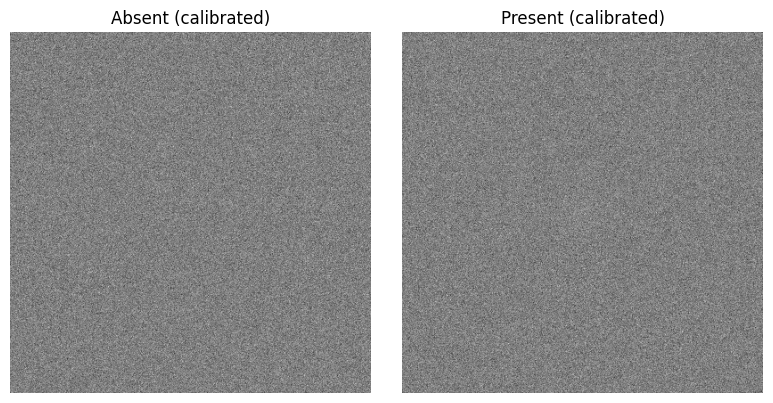

DISPLAY_GAIN = 4.5714 (28 cd/m^2 → 128.0 counts).


In [12]:

fig, axes = plt.subplots(1, 2, figsize=(8,4))

img_abs, noise_abs, sig_abs = make_stimulus(present=False, peak_contrast=PEAK_CONTRAST_EQUAL)
img_pre, noise_pre, sig_pre = make_stimulus(present=True,  peak_contrast=PEAK_CONTRAST_EQUAL)

axes[0].imshow(to_uint8_visible(img_abs), cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Absent (calibrated)'); axes[0].axis('off')

axes[1].imshow(to_uint8_visible(img_pre), cmap='gray', vmin=0, vmax=255)
axes[1].set_title('Present (calibrated)'); axes[1].axis('off')

plt.tight_layout(); plt.show()

print(f"DISPLAY_GAIN = {DISPLAY_GAIN:.4f} (28 cd/m^2 → {DISPLAY_MEAN_8BIT} counts).")


## Component view: Noise-only, Signal-only, Combined (Equal, calibrated)

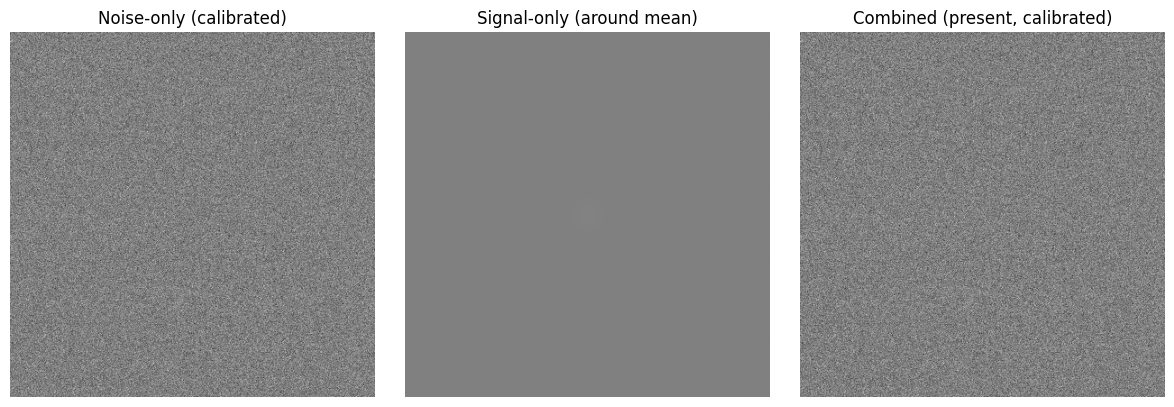

In [34]:

img, noise, signal = make_stimulus(present=True, peak_contrast=PEAK_CONTRAST_EQUAL)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].imshow(to_uint8_visible(noise), cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Noise-only (calibrated)'); axes[0].axis('off')

axes[1].imshow(to_uint8_visible_signal(signal), cmap='gray', vmin=0, vmax=255)
axes[1].set_title('Signal-only (around mean)'); axes[1].axis('off')

axes[2].imshow(to_uint8_visible(img), cmap='gray', vmin=0, vmax=255)
axes[2].set_title('Combined (present, calibrated)'); axes[2].axis('off')
plt.tight_layout(); plt.show()


## Verification: numeric checks on float arrays (cd/m²)

In [35]:

def signal_energy(blob): 
    return float(np.sum(blob**2))

def empirical_snr(blob, noise_sigma=NOISE_SD): 
    return np.sqrt(signal_energy(blob)) / noise_sigma

def check_condition(label, peak_contrast, target_snr):
    stim, noise, signal = make_stimulus(present=True, peak_contrast=peak_contrast)
    mean_lum = float(np.mean(noise))
    sd_noise = float(np.std(noise, ddof=1))
    rms = sd_noise / mean_lum
    amp = peak_contrast * MEAN_LUMINANCE
    snr = empirical_snr(signal, NOISE_SD)

    print(f"--- {label} condition ---")
    print(f"Image size          = {stim.shape} (target ~405×405)")
    print(f"Mean luminance      = {mean_lum:.2f}   (target ~28)")
    print(f"Noise SD            = {sd_noise:.3f}   (target ~4.375)")
    print(f"RMS contrast        = {rms:.4f}   (target ~0.1562)")
    print(f"Signal σ (px)       = {SIGMA_PX:.2f}   (target ~13.5)")
    print(f"Signal peak ampl.   = {amp:.3f}   cd/m²")
    print(f"Empirical SNR       = {snr:.2f}   (target ~{target_snr})")

# Run checks
check_condition("Equal (2%)",   PEAK_CONTRAST_EQUAL,  TARGET_SNRS["equal"])
check_condition("Weak (0.5%)",  PEAK_CONTRAST_WEAK,   TARGET_SNRS["weak"])
check_condition("Strong (9%)",  PEAK_CONTRAST_STRONG, TARGET_SNRS["strong"])


--- Equal (2%) condition ---
Image size          = (405, 405) (target ~405×405)
Mean luminance      = 28.00   (target ~28)
Noise SD            = 4.392   (target ~4.375)
RMS contrast        = 0.1568   (target ~0.1562)
Signal σ (px)       = 13.51   (target ~13.5)
Signal peak ampl.   = 0.560   cd/m²
Empirical SNR       = 3.07   (target ~3.07)
--- Weak (0.5%) condition ---
Image size          = (405, 405) (target ~405×405)
Mean luminance      = 28.00   (target ~28)
Noise SD            = 4.364   (target ~4.375)
RMS contrast        = 0.1559   (target ~0.1562)
Signal σ (px)       = 13.51   (target ~13.5)
Signal peak ampl.   = 0.140   cd/m²
Empirical SNR       = 0.77   (target ~0.77)
--- Strong (9%) condition ---
Image size          = (405, 405) (target ~405×405)
Mean luminance      = 28.01   (target ~28)
Noise SD            = 4.365   (target ~4.375)
RMS contrast        = 0.1558   (target ~0.1562)
Signal σ (px)       = 13.51   (target ~13.5)
Signal peak ampl.   = 2.520   cd/m²
Empirical SNR   

## Export dataset (calibrated PNGs for LLMs, optional .npy floats)

In [40]:

# === CONFIG ===
OUTPUT_DIR = Path("perceptual_dataset_calibrated")  # change if desired
TRIALS_PER_CONDITION = 200
SAVE_NPY = True         # save float arrays for verification/analysis
SAVE_SIGNAL_PNG = True  # save signal-only PNGs (visual QA)

def ensure_dirs(base: Path, cond: str):
    for label in ("absent", "present"):
        (base / cond / label / "combined").mkdir(parents=True, exist_ok=True)
        (base / cond / label / "noise").mkdir(parents=True, exist_ok=True)
        (base / cond / label / "signal").mkdir(parents=True, exist_ok=True)

def save_trial(out_dir: Path, cond: str, label: str, idx: int, combined, noise, signal):
    stem = f"{cond}_{label}_{idx:03d}"
    # PNGs (calibrated mapping)
    Image.fromarray(to_uint8_visible(combined)).save(out_dir/cond/label/"combined"/f"{stem}_combined.png")
    Image.fromarray(to_uint8_visible(noise)).save(out_dir/cond/label/"noise"/f"{stem}_noise.png")
    if SAVE_SIGNAL_PNG:
        Image.fromarray(to_uint8_visible_signal(signal)).save(out_dir/cond/label/"signal"/f"{stem}_signal.png")
    # Optional .npy floats
    if SAVE_NPY:
        np.save(out_dir/cond/label/"combined"/f"{stem}_combined.npy", combined)
        np.save(out_dir/cond/label/"noise"/f"{stem}_noise.npy", noise)
        np.save(out_dir/cond/label/"signal"/f"{stem}_signal.npy", signal)

def export_dataset():
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    conditions = {
        "equal":  {"contrast": PEAK_CONTRAST_EQUAL,  "target_snr": TARGET_SNRS["equal"]},
        "weak":   {"contrast": PEAK_CONTRAST_WEAK,   "target_snr": TARGET_SNRS["weak"]},
        "strong": {"contrast": PEAK_CONTRAST_STRONG, "target_snr": TARGET_SNRS["strong"]},
    }
    # Manifest
    (OUTPUT_DIR/"manifest.json").write_text(json.dumps({
        "MEAN_LUMINANCE": MEAN_LUMINANCE, "NOISE_SD": NOISE_SD, "FIELD_DEG": FIELD_DEG,
        "PIXELS_PER_DEG": PIXELS_PER_DEG, "IMG_SIZE": IMG_SIZE, "SIGMA_DEG": SIGMA_DEG,
        "SIGMA_PX": SIGMA_PX, "DISPLAY_GAIN": DISPLAY_GAIN,
        "PEAK_CONTRAST_EQUAL": PEAK_CONTRAST_EQUAL,
        "PEAK_CONTRAST_WEAK": PEAK_CONTRAST_WEAK,
        "PEAK_CONTRAST_STRONG": PEAK_CONTRAST_STRONG,
        "TARGET_SNRS": TARGET_SNRS, "TRIALS_PER_CONDITION": TRIALS_PER_CONDITION
    }, indent=2))

    # CSV metadata
    meta_path = OUTPUT_DIR/"metadata.csv"
    with meta_path.open("w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["trial_id","condition","label","contrast","target_snr",
                         "mean_noise","sd_noise","rms_contrast","empirical_snr_template",
                         "combined_png","noise_png","signal_png",
                         "combined_npy","noise_npy","signal_npy"])

        for cond, info in conditions.items():
            ensure_dirs(OUTPUT_DIR, cond)
            contrast = info["contrast"]; target_snr = info["target_snr"]
            # template norm on this grid (unit peak)
            tpl = gaussian_blob(IMG_SIZE, SIGMA_PX, amplitude=1.0)
            K = math.sqrt(np.sum(tpl**2))
            emp_snr_template = (contrast * MEAN_LUMINANCE * K) / NOISE_SD

            for i in range(1, TRIALS_PER_CONDITION+1):
                # Absent
                comb, noi, sig = make_stimulus(present=False, peak_contrast=contrast)
                save_trial(OUTPUT_DIR, cond, "absent", i, comb, noi, sig)
                mean_n, sd_n = float(np.mean(noi)), float(np.std(noi, ddof=1))
                rms = sd_n / mean_n
                writer.writerow([i,cond,"absent",contrast,target_snr,mean_n,sd_n,rms,emp_snr_template,
                                 str(OUTPUT_DIR/cond/"absent"/"combined"/f"{cond}_absent_{i:03d}_combined.png"),
                                 str(OUTPUT_DIR/cond/"absent"/"noise"/f"{cond}_absent_{i:03d}_noise.png"),
                                 str(OUTPUT_DIR/cond/"absent"/"signal"/f"{cond}_absent_{i:03d}_signal.png") if SAVE_SIGNAL_PNG else "",
                                 str(OUTPUT_DIR/cond/"absent"/"combined"/f"{cond}_absent_{i:03d}_combined.npy") if SAVE_NPY else "",
                                 str(OUTPUT_DIR/cond/"absent"/"noise"/f"{cond}_absent_{i:03d}_noise.npy") if SAVE_NPY else "",
                                 str(OUTPUT_DIR/cond/"absent"/"signal"/f"{cond}_absent_{i:03d}_signal.npy") if SAVE_NPY else ""])

                # Present
                comb, noi, sig = make_stimulus(present=True, peak_contrast=contrast)
                save_trial(OUTPUT_DIR, cond, "present", i, comb, noi, sig)
                mean_n, sd_n = float(np.mean(noi)), float(np.std(noi, ddof=1))
                rms = sd_n / mean_n
                writer.writerow([i,cond,"present",contrast,target_snr,mean_n,sd_n,rms,emp_snr_template,
                                 str(OUTPUT_DIR/cond/"present"/"combined"/f"{cond}_present_{i:03d}_combined.png"),
                                 str(OUTPUT_DIR/cond/"present"/"noise"/f"{cond}_present_{i:03d}_noise.png"),
                                 str(OUTPUT_DIR/cond/"present"/"signal"/f"{cond}_present_{i:03d}_signal.png") if SAVE_SIGNAL_PNG else "",
                                 str(OUTPUT_DIR/cond/"present"/"combined"/f"{cond}_present_{i:03d}_combined.npy") if SAVE_NPY else "",
                                 str(OUTPUT_DIR/cond/"present"/"noise"/f"{cond}_present_{i:03d}_noise.npy") if SAVE_NPY else "",
                                 str(OUTPUT_DIR/cond/"present"/"signal"/f"{cond}_present_{i:03d}_signal.npy") if SAVE_NPY else ""])

    print(f"[OK] Dataset exported to: {OUTPUT_DIR.resolve()} with calibrated PNGs.")


## Dataset verification (load from disk and compare to targets)

In [41]:

def empirical_snr_from_blob(blob, noise_sigma=NOISE_SD):
    return math.sqrt(float(np.sum(blob**2))) / noise_sigma

def verify_dataset(root="perceptual_dataset_calibrated", sample=20, use_npy=True, tol=0.05):
    root = Path(root)
    meta = root/"metadata.csv"
    if not meta.exists():
        raise FileNotFoundError(f"No metadata.csv under {root}")

    rows = []
    with meta.open("r", newline="") as f:
        reader = csv.DictReader(f)
        for r in reader:
            rows.append(r)

    # group by (condition,label)
    groups = {}
    for r in rows:
        key = (r["condition"], r["label"])
        groups.setdefault(key, []).append(r)

    # template norm
    tpl = gaussian_blob(IMG_SIZE, SIGMA_PX, amplitude=1.0)
    K = math.sqrt(np.sum(tpl**2))

    def load_arr(png_path, npy_path):
        p_npy = Path(npy_path)
        if use_npy and npy_path and p_npy.exists():
            return np.load(p_npy)
        # Fallback to PNG (already calibrated to 8-bit; convert back to float in counts)
        arr = np.array(Image.open(png_path)).astype(float) / DISPLAY_GAIN
        return arr

    all_ok = True
    for (cond, label), items in groups.items():
        n = min(sample, len(items))
        subset = random.sample(items, n)
        means, sds, rmss, snrs = [], [], [], []
        contrast = float(subset[0]["contrast"])
        target_snr = float(subset[0]["target_snr"])
        template_snr = (contrast * MEAN_LUMINANCE * K) / NOISE_SD

        for r in subset:
            noise = load_arr(r["noise_png"], r["noise_npy"])
            means.append(float(noise.mean()))
            sds.append(float(noise.std(ddof=1)))
            rmss.append(float(noise.std(ddof=1) / noise.mean()))
            if label == "present":
                signal = load_arr(r["signal_png"], r["signal_npy"])
                snrs.append(empirical_snr_from_blob(signal, NOISE_SD))

        def within(x, t):
            return abs(x - t) / max(abs(t), 1e-9) <= tol

        m_mean = float(np.mean(means))
        m_sd   = float(np.mean(sds))
        m_rms  = float(np.mean(rmss))
        m_snr  = float(np.mean(snrs)) if snrs else float("nan")

        ok_mean = within(m_mean, MEAN_LUMINANCE)
        ok_sd   = within(m_sd, NOISE_SD)
        ok_rms  = within(m_rms, NOISE_SD/MEAN_LUMINANCE)
        ok_snr  = True if not snrs else within(m_snr, target_snr)

        print(f"\n[Group] {cond}/{label}  n={n}")
        print(f"  mean luminance: {m_mean:.3f} (target {MEAN_LUMINANCE:.3f}) {'OK' if ok_mean else '!!'}")
        print(f"  noise sd     : {m_sd:.3f} (target {NOISE_SD:.3f}) {'OK' if ok_sd else '!!'}")
        print(f"  rms contrast : {m_rms:.4f} (target {NOISE_SD/MEAN_LUMINANCE:.4f}) {'OK' if ok_rms else '!!'}")
        if snrs:
            print(f"  empirical SNR: {m_snr:.2f} (target {target_snr:.2f}; template {template_snr:.2f}) {'OK' if ok_snr else '!!'}")

        all_ok &= ok_mean and ok_sd and ok_rms and ok_snr

    print("\n[RESULT] " + ("PASS ✔️ within tolerance" if all_ok else "FAIL ❌ exceeded tolerance"))
    return all_ok


## Gallery: each image type for all conditions (calibrated)

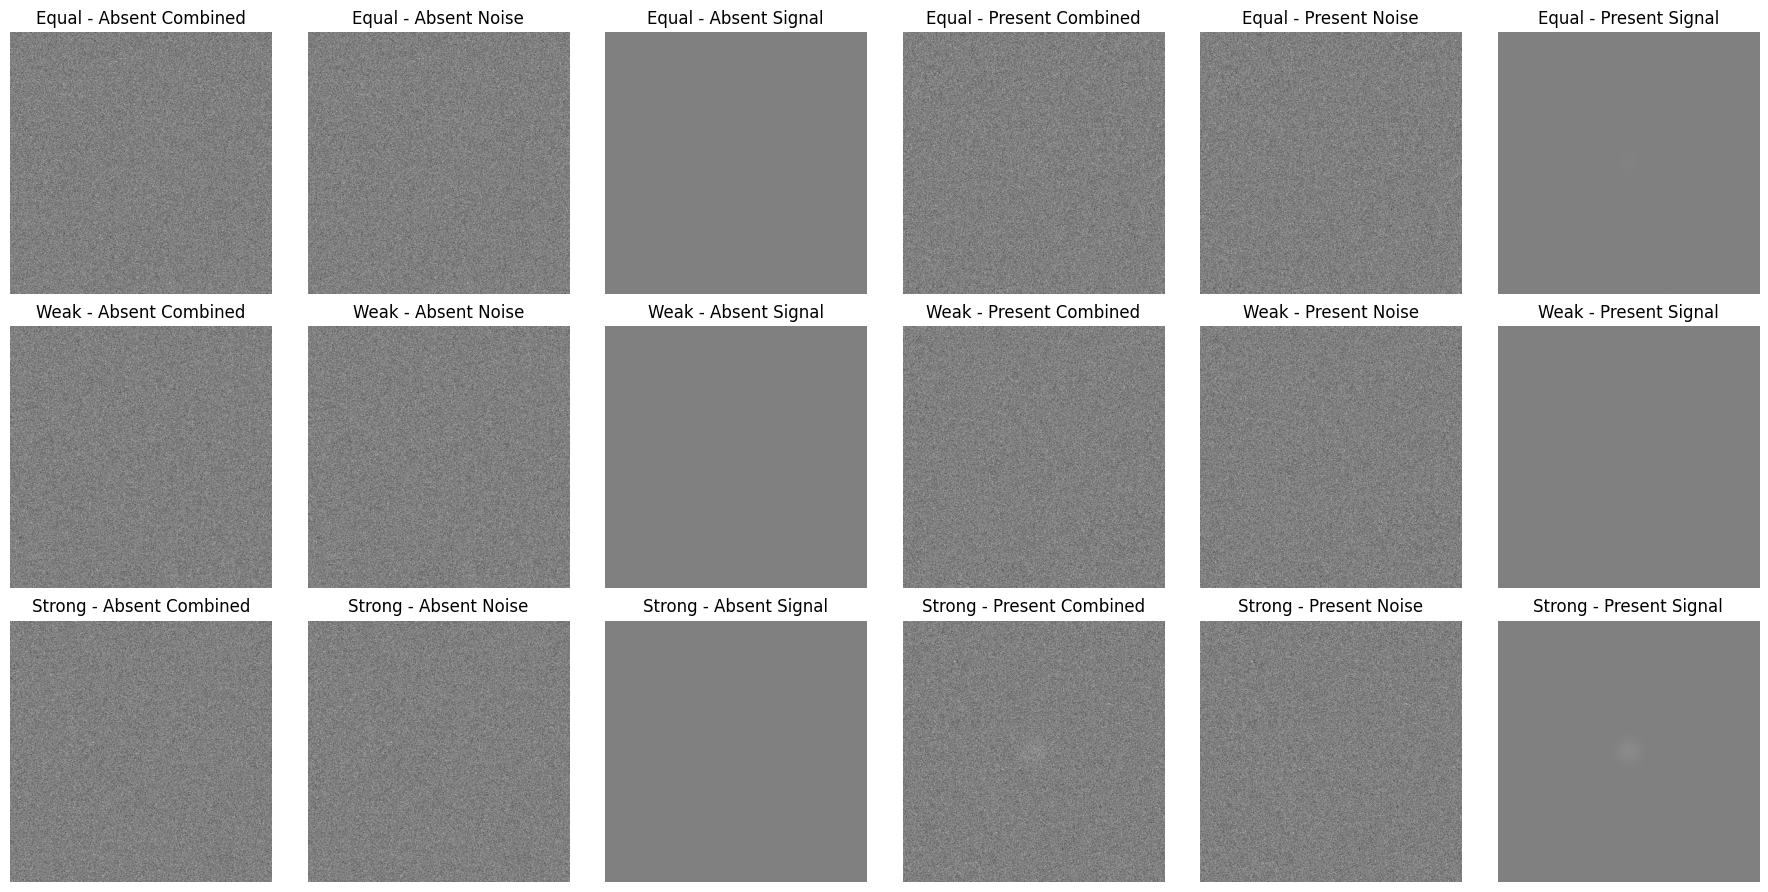

In [42]:

conditions = {
    "equal":  {"contrast": PEAK_CONTRAST_EQUAL},
    "weak":   {"contrast": PEAK_CONTRAST_WEAK},
    "strong": {"contrast": PEAK_CONTRAST_STRONG},
}

fig, axes = plt.subplots(len(conditions), 6, figsize=(18, 3*len(conditions)))

for row, (cond, info) in enumerate(conditions.items()):
    contrast = info["contrast"]
    # absent / present
    c_abs, n_abs, s_abs = make_stimulus(present=False, peak_contrast=contrast)
    c_pre, n_pre, s_pre = make_stimulus(present=True,  peak_contrast=contrast)

    # Absent
    axes[row, 0].imshow(to_uint8_visible(c_abs), cmap="gray", vmin=0, vmax=255)
    axes[row, 0].set_title(f"{cond.capitalize()} - Absent Combined"); axes[row, 0].axis("off")
    axes[row, 1].imshow(to_uint8_visible(n_abs), cmap="gray", vmin=0, vmax=255)
    axes[row, 1].set_title(f"{cond.capitalize()} - Absent Noise"); axes[row, 1].axis("off")
    axes[row, 2].imshow(to_uint8_visible_signal(s_abs), cmap="gray", vmin=0, vmax=255)
    axes[row, 2].set_title(f"{cond.capitalize()} - Absent Signal"); axes[row, 2].axis("off")

    # Present
    axes[row, 3].imshow(to_uint8_visible(c_pre), cmap="gray", vmin=0, vmax=255)
    axes[row, 3].set_title(f"{cond.capitalize()} - Present Combined"); axes[row, 3].axis("off")
    axes[row, 4].imshow(to_uint8_visible(n_pre), cmap="gray", vmin=0, vmax=255)
    axes[row, 4].set_title(f"{cond.capitalize()} - Present Noise"); axes[row, 4].axis("off")
    axes[row, 5].imshow(to_uint8_visible_signal(s_pre), cmap="gray", vmin=0, vmax=255)
    axes[row, 5].set_title(f"{cond.capitalize()} - Present Signal"); axes[row, 5].axis("off")

plt.tight_layout(); plt.show()


In [44]:
# --- ONE-CLICK EXPORT & MIRROR TO allimgs/ ---

import shutil
from pathlib import Path
import pandas as pd
from PIL import Image
import numpy as np

# 1) Ensure the calibrated dataset exists (creates PNGs + metadata if missing)
DATASET_ROOT = Path("perceptual_dataset_calibrated")
if not (DATASET_ROOT / "metadata.csv").exists():
    print("[info] No calibrated dataset found yet — exporting now…")
    export_dataset()  # <-- uses your calibrated mapping & settings from above

# 2) Verify we actually have combined PNGs (the stimuli to show LLMs)
pngs = sorted((DATASET_ROOT).glob("*/*/combined/*_combined.png"))
if not pngs:
    # If you saved only .npy, rebuild calibrated PNGs from floats
    print("[warn] No combined PNGs found — rebuilding from .npy …")
    comb_npys = sorted((DATASET_ROOT).glob("*/*/combined/*_combined.npy"))
    if not comb_npys:
        raise FileNotFoundError(f"No combined PNGs or NPYS found under {DATASET_ROOT}/**/combined")
    # Use your calibrated mapping
    def to_uint8_visible(lum_float):
        return np.clip(lum_float * DISPLAY_GAIN, 0, 255).astype(np.uint8)
    rebuilt = 0
    for npy_path in comb_npys:
        arr = np.load(npy_path)
        png_path = npy_path.with_suffix(".png")
        png_path.parent.mkdir(parents=True, exist_ok=True)
        Image.fromarray(to_uint8_visible(arr)).save(png_path)
        rebuilt += 1
    print(f"[ok] Rebuilt {rebuilt} combined PNGs.")
    pngs = sorted((DATASET_ROOT).glob("*/*/combined/*_combined.png"))

# 3) Mirror to a flat allimgs/ folder and write index.csv
ALLIMGS_DIR = Path("allimgs")
ALLIMGS_DIR.mkdir(parents=True, exist_ok=True)

rows = []
for k, p in enumerate(pngs, start=1):
    # path: ROOT / condition / label / combined / fname.png
    cond  = p.parts[-4]
    label = p.parts[-3]
    new_name = f"{cond}_{label}_{k:05d}.png"
    dst = ALLIMGS_DIR / new_name
    shutil.copy2(p, dst)
    rows.append({"id": k, "condition": cond, "label": label, "src": str(p), "img": str(dst)})

index_df = pd.DataFrame(rows)
index_df.to_csv(ALLIMGS_DIR / "index.csv", index=False)

print(f"[ok] Copied {len(index_df)} images to {ALLIMGS_DIR}/")
print(f"[ok] Wrote manifest: {ALLIMGS_DIR/'index.csv'}")
index_df.head()


[info] No calibrated dataset found yet — exporting now…
[OK] Dataset exported to: /workspaces/Honors_Project/perceptual_dataset_calibrated with calibrated PNGs.
[ok] Copied 1200 images to allimgs/
[ok] Wrote manifest: allimgs/index.csv


,id,condition,label,src,img
0,1,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00001.png
1,2,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00002.png
2,3,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00003.png
3,4,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00004.png
4,5,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00005.png


In [46]:
import shutil
from pathlib import Path
import pandas as pd

# Point this to the dataset you generated earlier
DATASET_ROOT = Path("perceptual_dataset_calibrated")  # or perceptual_dataset
ALLIMGS_DIR = Path("allimgs")
ALLIMGS_DIR.mkdir(exist_ok=True, parents=True)

# Grab the actual stimuli (combined PNGs) across all conditions/labels
pngs = sorted((DATASET_ROOT).glob("*/*/combined/*_combined.png"))
if not pngs:
    raise FileNotFoundError(f"No combined PNGs found under {DATASET_ROOT}/**/combined")

rows = []
for k, p in enumerate(pngs, start=1):
    # Parse condition/label from path: DATASET_ROOT / cond / label / combined / fname.png
    cond = p.parts[-4]
    label = p.parts[-3]
    # Copy into flat allimgs/ for your existing scripts
    new_name = f"{cond}_{label}_{k:05d}.png"
    dst = ALLIMGS_DIR / new_name
    shutil.copy2(p, dst)
    rows.append({"id": k, "condition": cond, "label": label, "src": str(p), "img": str(dst)})

index_df = pd.DataFrame(rows)
index_df.to_csv(ALLIMGS_DIR / "index.csv", index=False)
index_df.head()


,id,condition,label,src,img
0,1,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00001.png
1,2,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00002.png
2,3,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00003.png
3,4,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00004.png
4,5,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00005.png


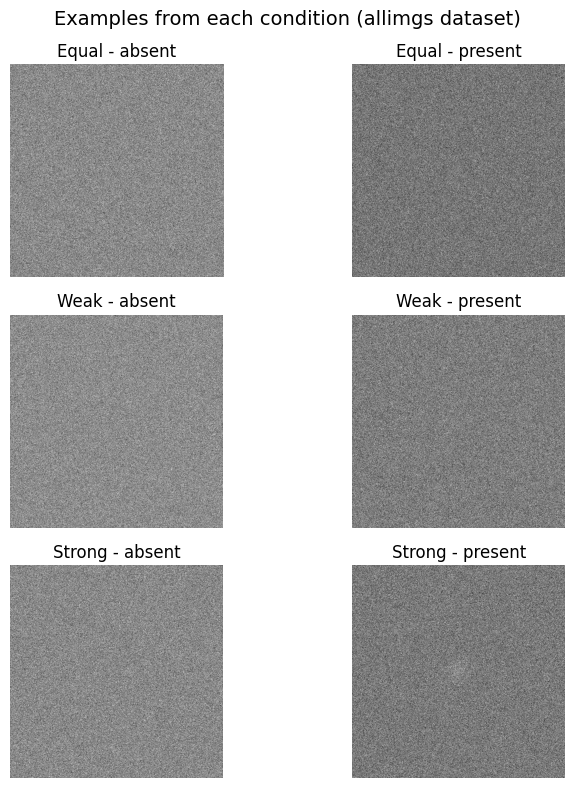

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

# Load your flat manifest
index_df = pd.read_csv("allimgs/index.csv")

# Pick one random example for each condition × label
conditions = ["equal", "weak", "strong"]
labels = ["absent", "present"]

fig, axes = plt.subplots(len(conditions), len(labels), figsize=(8, 8))

for i, cond in enumerate(conditions):
    for j, label in enumerate(labels):
        subset = index_df[(index_df["condition"] == cond) & (index_df["label"] == label)]
        if subset.empty:
            axes[i, j].set_title(f"{cond}-{label}\n(no images)")
            axes[i, j].axis("off")
            continue
        # Pick a random row
        row = subset.sample(1).iloc[0]
        img = Image.open(row["img"])
        axes[i, j].imshow(img, cmap="gray")
        axes[i, j].set_title(f"{cond.capitalize()} - {label}")
        axes[i, j].axis("off")

plt.suptitle("Examples from each condition (allimgs dataset)", fontsize=14)
plt.tight_layout()
plt.show()


[CHECK] Using DISPLAY_GAIN=4.5714; 28 cd/m^2 -> 128.0 counts

 equal/absent   n=6 | mean=27.895 (OK)  sd= 4.374 (OK)  rms= 0.1568 (OK)
 equal/present  n=6 | mean=27.898 (OK)  sd= 4.372 (OK)  rms= 0.1567 (OK)  | matched-filter peak ~ 400.37
  weak/absent   n=6 | mean=27.893 (OK)  sd= 4.369 (OK)  rms= 0.1566 (OK)
  weak/present  n=6 | mean=27.891 (OK)  sd= 4.376 (OK)  rms= 0.1569 (OK)  | matched-filter peak ~ 315.82
strong/absent   n=6 | mean=27.892 (OK)  sd= 4.371 (OK)  rms= 0.1567 (OK)
strong/present  n=6 | mean=27.910 (OK)  sd= 4.378 (OK)  rms= 0.1569 (OK)  | matched-filter peak ~ 1508.75

[RESULT] PASS ✔️ basic stats within tolerance


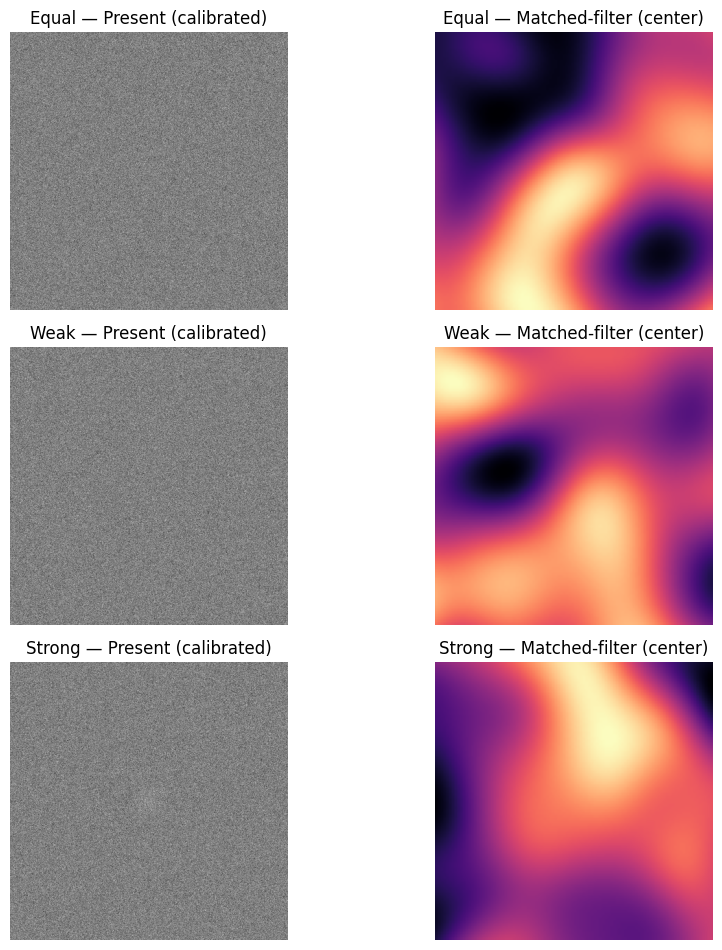

In [48]:
# === Sanity check & visualization for the new calibrated dataset (allimgs/) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random, math

ALLIMGS_DIR = Path("allimgs")
INDEX_CSV = ALLIMGS_DIR / "index.csv"
assert INDEX_CSV.exists(), f"index.csv not found at {INDEX_CSV}"

# Helper: convert 8-bit counts (saved with calibrated DISPLAY_GAIN) back to cd/m^2
def counts_to_luminance(arr_counts):
    return arr_counts.astype(float) / DISPLAY_GAIN

def empirical_snr_from_blob(signal_float):
    return math.sqrt(float(np.sum(signal_float**2))) / NOISE_SD

# Build the Gaussian template once (unit peak) for matched filter
def gaussian_template(size, sigma_px):
    h = w = size
    cy, cx = (h-1)/2.0, (w-1)/2.0
    y = np.arange(h)[:, None]
    x = np.arange(w)[None, :]
    g = np.exp(-(((y - cy)**2 + (x - cx)**2) / (2*sigma_px**2)))
    g -= g.mean()  # zero-mean for correlation
    return g

TEMPLATE = gaussian_template(IMG_SIZE, SIGMA_PX)
TPL_NORM = np.sqrt((TEMPLATE**2).sum())

def matched_filter_response(img_counts):
    """Return correlation map using FFT on counts converted back to luminance (float)."""
    img = counts_to_luminance(img_counts)
    img = img - img.mean()
    F_img = np.fft.rfft2(img)
    F_tpl = np.fft.rfft2(TEMPLATE)
    corr = np.fft.irfft2(F_img * np.conj(F_tpl), s=img.shape)
    return corr

# Load manifest
idx = pd.read_csv(INDEX_CSV)

# Parameters
SAMPLES_PER_GROUP = 6          # how many random images per condition×label to check numerically
TOL = 0.07                     # 7% tolerance on stats
conditions = ["equal", "weak", "strong"]
labels = ["absent", "present"]

def within(x, target, tol=TOL):
    return abs(x - target) / max(abs(target), 1e-9) <= tol

# --- Numeric checks across random samples ---
all_ok = True
print(f"[CHECK] Using DISPLAY_GAIN={DISPLAY_GAIN:.4f}; 28 cd/m^2 -> {DISPLAY_GAIN*MEAN_LUMINANCE:.1f} counts\n")
for cond in conditions:
    for lab in labels:
        subset = idx[(idx["condition"] == cond) & (idx["label"] == lab)]
        if subset.empty:
            print(f"[WARN] No images for {cond}/{lab}")
            all_ok = False
            continue
        sample_rows = subset.sample(min(SAMPLES_PER_GROUP, len(subset)), random_state=None)
        means, sds, rmss, peaks = [], [], [], []

        for _, r in sample_rows.iterrows():
            img_counts = np.array(Image.open(r["img"]))
            lum = counts_to_luminance(img_counts)
            m = float(lum.mean())
            sd = float(lum.std(ddof=1))
            means.append(m)
            sds.append(sd)
            rmss.append(sd / m)

            if lab == "present":
                corr = matched_filter_response(img_counts)
                peaks.append(float(corr.max()))

        mean_mean = float(np.mean(means))
        mean_sd   = float(np.mean(sds))
        mean_rms  = float(np.mean(rmss))

        ok_mean = within(mean_mean, MEAN_LUMINANCE)
        ok_sd   = within(mean_sd, NOISE_SD)
        ok_rms  = within(mean_rms, NOISE_SD / MEAN_LUMINANCE)

        print(f"{cond:>6}/{lab:<7}  n={len(sample_rows)} | "
              f"mean={mean_mean:6.3f} ({'OK' if ok_mean else '!!'})  "
              f"sd={mean_sd:6.3f} ({'OK' if ok_sd else '!!'})  "
              f"rms={mean_rms:7.4f} ({'OK' if ok_rms else '!!'})", end="")

        if lab == "present" and peaks:
            # Report matched-filter peak (bigger is stronger; no hard target, but should be > absent typical)
            print(f"  | matched-filter peak ~ {np.mean(peaks):.2f}")
        else:
            print()

        all_ok &= ok_mean and ok_sd and ok_rms

print("\n[RESULT]", "PASS ✔️ basic stats within tolerance" if all_ok else "ATTN ⚠️ some groups exceed tolerance")

# --- Visual check: one present example per condition + matched-filter map ---
fig, axes = plt.subplots(len(conditions), 2, figsize=(10, 3.2*len(conditions)))
for i, cond in enumerate(conditions):
    pres = idx[(idx["condition"] == cond) & (idx["label"] == "present")]
    if pres.empty:
        axes[i,0].set_axis_off(); axes[i,1].set_axis_off()
        axes[i,0].set_title(f"{cond} present: (none)")
        continue
    row = pres.sample(1).iloc[0]
    img_counts = np.array(Image.open(row["img"]))
    corr = matched_filter_response(img_counts)

    axes[i,0].imshow(img_counts, cmap="gray", vmin=0, vmax=255)
    axes[i,0].set_title(f"{cond.capitalize()} — Present (calibrated)")
    axes[i,0].axis("off")

    # center crop of correlation for clarity
    sz = 100
    cy, cx = corr.shape[0]//2, corr.shape[1]//2
    corr_crop = corr[cy - sz//2: cy + sz//2, cx - sz//2: cx + sz//2]
    im = axes[i,1].imshow(corr_crop, cmap="magma")
    axes[i,1].set_title(f"{cond.capitalize()} — Matched-filter (center)")
    axes[i,1].axis("off")

plt.tight_layout(); plt.show()


In [49]:
# ---- Set up Git-friendly dataset structure without committing images ----
from pathlib import Path
import os, json

REPO_ROOT = Path(".").resolve()

# Paths you’re using
DATASET_DIR = REPO_ROOT / "perceptual_dataset_calibrated"
ALLIMGS_DIR = REPO_ROOT / "allimgs"
NB_TO_KEEP  = REPO_ROOT / "Perceptual_Image_Generator_Calibrated.ipynb"

# 1) Create a repo-level .gitignore with rules that:
#    - ignore PNG/NPY anywhere,
#    - but keep metadata and your notebook.
gitignore = REPO_ROOT / ".gitignore"

gitignore_rules = f"""
# --- Ignore large artifacts globally ---
*.png
*.npy

# --- Always keep notebooks and metadata ---
!Perceptual_Image_Generator_Calibrated.ipynb
!**/metadata.csv
!**/manifest.json
!allimgs/index.csv

# If you export other CSV manifests, keep them:
!**/*.csv

# Optional: ignore common caches
.ipynb_checkpoints/
__pycache__/
*.DS_Store
"""

gitignore.write_text(gitignore_rules.strip() + "\n")
print(f"[ok] Wrote {gitignore}")

# 2) Ensure dataset directories exist (so we can add .gitkeep placeholders)
for p in [
    DATASET_DIR / "equal" / "absent" / "combined",
    DATASET_DIR / "equal" / "absent" / "noise",
    DATASET_DIR / "equal" / "absent" / "signal",
    DATASET_DIR / "equal" / "present" / "combined",
    DATASET_DIR / "equal" / "present" / "noise",
    DATASET_DIR / "equal" / "present" / "signal",
    DATASET_DIR / "weak"  / "absent" / "combined",
    DATASET_DIR / "weak"  / "absent" / "noise",
    DATASET_DIR / "weak"  / "absent" / "signal",
    DATASET_DIR / "weak"  / "present" / "combined",
    DATASET_DIR / "weak"  / "present" / "noise",
    DATASET_DIR / "weak"  / "present" / "signal",
    DATASET_DIR / "strong"/ "absent" / "combined",
    DATASET_DIR / "strong"/ "absent" / "noise",
    DATASET_DIR / "strong"/ "absent" / "signal",
    DATASET_DIR / "strong"/ "present" / "combined",
    DATASET_DIR / "strong"/ "present" / "noise",
    DATASET_DIR / "strong"/ "present" / "signal",
]:
    p.mkdir(parents=True, exist_ok=True)
    (p / ".gitkeep").touch()

# Keep top-level dataset files if present
for meta in ["metadata.csv", "manifest.json"]:
    f = DATASET_DIR / meta
    if f.exists():
        print(f"[info] Found {f.name} — will be kept (not ignored)")

# 3) allimgs/ — keep just the index.csv; ignore the images
ALLIMGS_DIR.mkdir(parents=True, exist_ok=True)
(ALLIMGS_DIR / ".gitkeep").touch()
# If you already created index.csv earlier, it will be committed since we whitelisted it in .gitignore

print("[ok] Placed .gitkeep files to preserve folder tree without committing images.")
print("\nNext steps (run in a terminal):")
print("  git add .gitignore Perceptual_Image_Generator_Calibrated.ipynb")
print("  git add perceptual_dataset_calibrated/**/.gitkeep perceptual_dataset_calibrated/metadata.csv perceptual_dataset_calibrated/manifest.json")
print("  git add allimgs/index.csv allimgs/.gitkeep")
print('  git commit -m "Add dataset structure, metadata, and notebook; ignore large image files"')
print("  git push")


[ok] Wrote /workspaces/Honors_Project/.gitignore
[info] Found metadata.csv — will be kept (not ignored)
[info] Found manifest.json — will be kept (not ignored)
[ok] Placed .gitkeep files to preserve folder tree without committing images.

Next steps (run in a terminal):
  git add .gitignore Perceptual_Image_Generator_Calibrated.ipynb
  git add perceptual_dataset_calibrated/**/.gitkeep perceptual_dataset_calibrated/metadata.csv perceptual_dataset_calibrated/manifest.json
  git add allimgs/index.csv allimgs/.gitkeep
  git commit -m "Add dataset structure, metadata, and notebook; ignore large image files"
  git push
